In [53]:
import math
import sys
import numpy as np
import matplotlib.pyplot as plt

## 1. Random Data Gen
### a. Univariate gaussian data gen

In [54]:
def uni_gaus(m, s):
    #Central Limit Theorem
    X = np.sum(np.random.uniform(0.0, 1.0, 12)) - 6
    return X * s**0.5 + m

In [55]:
# initial parameters
m = 3
s = 0.1

uni_gaus(m, s)

3.153996448314816

### b. Polynomial basis linear model data generator

In [56]:
def polyGen(n, a, w):
    x = np.random.uniform(-1, 1)
    y = 0
    for i in range(n):
        y += w[i] * x**i 
    y += uni_gaus(x, a)
    return x, y

In [57]:
# initial parameters
n = 3
a = 10
w = np.asarray([0.2, 0.3, 0.4])

polyGen(n, a, w)

(-0.9626392438815403, -0.9051009730335804)

# 2. Sequential Estimator

In [58]:
def update(existingAggregate, x):
    (counter, mean, M2) = existingAggregate
    counter += 1
    delta = x - mean
    mean += delta / counter
    delta2 = x - mean
    M2 += delta * delta2
    var = M2 / counter
    sampleVar = M2 / (counter - 1)
    return (counter, mean, sampleVar, M2)

In [59]:
def sequential(m, s):
    print('Data point source function: N({0}, {1})\n'.format(m, s))
    counter = 0
    mean = 0
    M2 = 0
    while True:
        x = uni_gaus(m, s)
        print('Add data point: ', x)
        if counter == 0:
            counter += 1
            existingAggregate = (counter, x, M2)
            
        else:
            existingAggregate = (counter, mean, M2)
        counter, mean, new_sV, M2 = update(existingAggregate, x)
        if abs(mean - m) <= 1e-2 and abs(new_sV - s) <= 1e-2:
            print('\nMean = {0} Variance = {1}'.format(mean, new_sV))
            break

        print('Mean = {0} Variance = {1}'.format(mean, new_sV))

In [60]:
# initial parameters
m = 3.0
s = 5.0
sequential(m, s)

Data point source function: N(3.0, 5.0)

Add data point:  1.718208583500687
Mean = 1.718208583500687 Variance = 0.0
Add data point:  3.384139381814486
Mean = 2.2735188496052867 Variance = 0.9251084749234838
Add data point:  3.1945349716804805
Mean = 2.5037728801240853 Variance = 0.8288066575629296
Add data point:  4.556426167208201
Mean = 2.9143035375409085 Variance = 1.4642820965676422
Add data point:  3.3910587860648214
Mean = 2.9937627456282274 Variance = 1.2093082717532968
Add data point:  9.142692353049547
Mean = 3.87218126097413 Variance = 6.409090509845247
Add data point:  5.150512089774199
Mean = 4.031972614574139 Variance = 5.69777236477851
Add data point:  3.8114153204097794
Mean = 4.007466248555876 Variance = 4.990955876959986
Add data point:  4.618854168069043
Mean = 4.068605040507193 Variance = 4.473784742777095
Add data point:  0.330466948924077
Mean = 3.728774304908728 Variance = 5.296740485930719
Add data point:  1.778872597963664
Mean = 3.5662824959966395 Variance = 5.

# 3. Bayesian Linear regression

In [61]:
def make_design(x, n):
    X = np.zeros((1, n))
    for i in range(n):
        X[0, i] = x**i
    return X

In [62]:
def transpose(x):
    transpose = []
    for i in range(len(x[0])):
        temp = []
        for j in range(len(x)):
            temp.append(x[j][i])
        transpose.append(temp)
    return np.asarray(transpose)

In [63]:
def mul(A, B):
    result = []
    for i in range(len(A)):
        temp = []
        for j in range(len(B[0])):
            temp.append(0)
        result.append(temp)
    for i in range(len(A)):
        for j in range(len(B[0])):
            for k in range(len(B)):
                result[i][j] += A[i][k] * B[k][j]
    return np.asarray(result)

### Visualsation

In [64]:
def draw_lines(x, y, var, lower_bound, upper_bound):
    plt.plot(x, y, color = 'black')
    plt.plot(x, y+var, color = 'red')
    plt.plot(x, y-var, color = 'red')
    
    plt.xlim(-2, 2)
    plt.ylim([lower_bound, upper_bound])

def vizualize(x_gen, grTR, mean, covar, tenth_mean, tenth_covar, fifth_mean, fifth_covar, n, num_point=25):
    x = np.linspace(-2.0, 2.0, num_point)
    plt.figure(figsize=(10,8))
    # Plot ground truth
    plt.subplot(221)
    func = np.poly1d(np.flip(w))
    y = func(x)
    var = (1/a)
    upper_bound = max(grTR) + 10
    lower_bound = min(grTR) - 10
    plt.title("Ground truth")
    draw_lines(x, y, var, lower_bound, upper_bound)

    # Final predict result
    plt.subplot(222)
    func = np.poly1d(np.flip(np.reshape(mean, n)))
    y = func(x)
    var = np.zeros((num_point))
    for i in range(num_point):
        X = make_design(x[i], n)
        var[i] = 1/a +  mul(X, mul(covar, (transpose(X))))[0][0]
    plt.title("Predict result")
    plt.scatter(x_gen, grTR)
    draw_lines(x, y, var, lower_bound, upper_bound)

    # At the time that have seen 10 data points
    plt.subplot(223)
    func = np.poly1d(np.flip(np.reshape(tenth_mean, n)))
    y = func(x)
    var = np.zeros((num_point))
    for i in range(num_point):
        X = make_design(x[i], n)
        var[i] = 1/a +  mul(X, mul(tenth_covar, (transpose(X))))[0][0]
    plt.title("After 10 incomes")
    plt.scatter(x_gen[0:10], grTR[0:10])
    draw_lines(x, y, var, lower_bound, upper_bound)
    

    #At the time that have seen 50 data points
    plt.subplot(224)
    func = np.poly1d(np.flip(np.reshape(fifth_mean, n)))
    y = func(x)
    var = np.zeros((num_point))
    for i in range(num_point):
        X = make_design(x[i], n) 
        var[i] = 1/a +  mul(X, mul(fifth_covar, (transpose(X))))[0][0]
    plt.title("After 50 incomes")
    plt.scatter(x_gen[0:50], grTR[0:50])
    draw_lines(x, y, var, lower_bound, upper_bound)

    plt.tight_layout()
    plt.show()

In [65]:
def baysian_linear_regression(a):
    
    a_copy = a
    a = 1 / a
    mean = np.zeros((1, n))
    x_gen = []
    grTr = []
    counter = 0
    
    while True:
        x_new, y_new = polyGen(n, a_copy, w)
        X = make_design(x_new, n)
        x_gen.append(x_new)
        grTr.append(y_new)

        if counter == 0:
            bI = b * np.eye(n)
            covar_poster = a * mul(transpose(X), X) + bI
            mean_poster = a * mul(np.linalg.inv(covar_poster), transpose(X)) * y_new
        else:
            covar_poster = a * transpose(X).dot(X) + covar
            mean_poster = np.linalg.inv(covar_poster).dot(a * transpose(X).dot(y_new) + covar.dot(mean))

        # for 10th record
        if counter == 9:
            tenth_mean = mean_poster.copy()
            tenth_covar = np.linalg.inv(covar_poster).copy()
        if counter == 49:
            fifth_mean = mean_poster.copy()
            fifth_covar = np.linalg.inv(covar_poster).copy()

        mean_margin = mul(X, mean_poster)
        covar_margin = ((1 / a) + X.dot(np.linalg.inv(covar_poster).dot(transpose(X))))
        
        # Print the new data point and the current paramters 
        # for posterior and predictive distribution
        print('Add data point ({0}, {1})'.format(x_new, y_new))
        print('Posterior mean:')
        for i in range(n):
            print(' ', format(mean_poster[i, 0], '0.10f'))

        print('Posterior Variance:')
        for i in range(n):
            print(' ', end=' ')
            for j in range(n):
                if j == n - 1:
                    print( format(covar_poster[i, j], '0.10f') , end=' ')
                else:
                    print( format(covar_poster[i, j], '0.10f') , end=', ')
            print(' ')
        print('Predictive distribution ~ N({0}, {1})'.format(mean_margin[0, 0], covar_margin[0, 0]))
        print('---------------------------------------------------------------------')
        if np.linalg.norm(mean - mean_poster, ord=2) < 1e-2 and counter > 1000:
                break

        # Update parameters
        counter += 1
        covar = covar_poster
        mean = mean_poster

    return x_gen, grTr, mean_poster, np.linalg.inv(covar_poster), tenth_mean, tenth_covar, fifth_mean, fifth_covar

## Input 

In [66]:
b = 1
n = 4
a = 1  
w = np.array([1.0, 2.0, 3.0, 4.0])

x_gen, grTr, mean_poster, covar_poster, tenth_mean, tenth_covar, fifth_mean, fifth_covar = baysian_linear_regression(a)

Add data point (-0.1774977632596555, 0.9425911184628789)
Posterior mean:
  0.4637527776
  -0.0823150807
  0.0146107427
  -0.0025933742
Posterior Variance:
  2.0000000000, -0.1774977633, 0.0315054560, -0.0055921480  
  -0.1774977633, 1.0315054560, -0.0055921480, 0.0009925938  
  0.0315054560, -0.0055921480, 1.0009925938, -0.0001761832  
  -0.0055921480, 0.0009925938, -0.0001761832, 1.0000312721  
Predictive distribution ~ N(0.4788383409082423, 1.5080021777513704)
---------------------------------------------------------------------
Add data point (-0.10943371229903565, -0.16113793274199018)
Posterior mean:
  0.2531923517
  -0.0737045795
  0.0162300950
  -0.0032252697
Posterior Variance:
  3.0000000000, -0.2869314756, 0.0434811933, -0.0069026974  
  -0.2869314756, 1.0434811933, -0.0069026974, 0.0011360120  
  0.0434811933, -0.0069026974, 1.0011360120, -0.0001918780  
  -0.0069026974, 0.0011360120, -0.0001918780, 1.0000329897  
Predictive distribution ~ N(0.2614567116490999, 1.33352801178

## Visualization

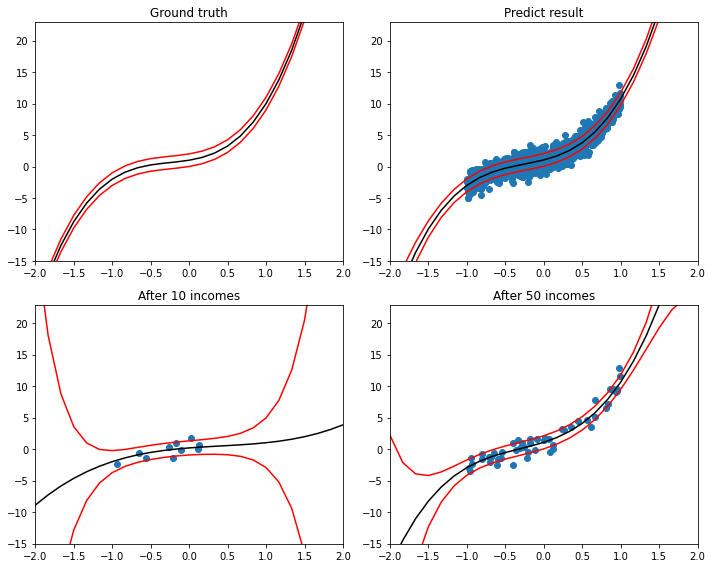

In [67]:
vizualize(x_gen, grTr, mean_poster, covar_poster, tenth_mean, tenth_covar, fifth_mean, fifth_covar, n)